In [1]:
!pip install wbgapi

You should consider upgrading via the '/Users/mac/.pyenv/versions/3.10.3/bin/python3.10 -m pip install --upgrade pip' command.


In [4]:
import wbgapi as wb
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
from datetime import datetime
from dataclasses import dataclass

In [5]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Query the environmental score, methane emission (kt of CO2 equivalent)
- #### Methane emissions from energy processes are emissions from the production, handling, transmission, and combustion of fossil fuels and biofuels.
- #### At standard temperature and pressure, one metric ton of carbon dioxide (CO₂) would fill a sphere 32 feet (about 9.8 meters) in diameter. The average car in the U.S. will produce this over a three-month period.

In [6]:
wb.series.info(q='methane')

id,value
EN.ATM.METH.AG.KT.CE,Agricultural methane emissions (thousand metric tons of CO2 equivalent)
EN.ATM.METH.AG.ZS,Agricultural methane emissions (% of total)
EN.ATM.METH.EG.KT.CE,Methane emissions in energy sector (thousand metric tons of CO2 equivalent)
EN.ATM.METH.EG.ZS,Energy related methane emissions (% of total)
EN.ATM.METH.KT.CE,Methane emissions (kt of CO2 equivalent)
EN.ATM.METH.ZG,Methane emissions (% change from 1990)
,6 elements


In [7]:
QUERY_ID = ['EN.ATM.METH.EG.KT.CE']

predictors_id = ['EN.ATM.METH.EG.ZS', 'EN.ATM.METH.EG.ZS',
                 'EN.ATM.METH.ZG', 'EN.ATM.METH.AG.ZS', 'EN.ATM.METH.AG.KT.CE' ]

predictors_id_2 = ['EN.ATM.CO2E.KT', 'EG.USE.PCAP.KG.OE',
                 'NV.IND.TOTL.ZS' ]

CURRENT_YEAR_AVAILABLE = 2021

#### GET OUR DATA FROM WORLD BANK API

We retrieve the data from the API using CountryAlpha2Code and the period time
- CountryAlpha2Code : later.....
- period time : later....

In [19]:
def HandlingPeriodFormatInput(period_time) :
    
    if not isinstance(period_time, list):      
        raise Exception ("period time should be in a format list like this : [2021]")

    if len(period_time) > 3 :
        raise Exception ("The format given is not correct try this format [initial date, final date, step")
        
    if len(period_time) == 2 :
        period_time.insert(2, 1)
        warnings.warn("the format should be [initial date, final date, step")

    if max(period_time) > CURRENT_YEAR_AVAILABLE + 1 or min(period_time) > CURRENT_YEAR_AVAILABLE:

        new_period_time = range(min(2021, period_time[0]), min(2022, period_time[1]), period_time[2])
    else :
         new_period_time = range(period_time[0], period_time[1], period_time[2])

    return new_period_time


In [9]:
HandlingPeriodFormatInput([2010, 2026, 1])

(range(2010, 2022), 2010, 2026)

In [22]:
@dataclass
class Country : 
    name : str
    CountryAlpha2Code : str
    period_time : list
    query_id : list

    def getDataMethEmissionByCountryAndYears(self) -> pd.DataFrame :
        period_time_range = HandlingPeriodFormatInput(self.period_time)
        df = wb.data.DataFrame(self.query_id, self.CountryAlpha2Code, time = period_time_range, columns='series')   
        return df.reset_index()
        

In [38]:
France = Country('France', 'FRA', [1960, 2026, 1], QUERY_ID)
France.period_time

[1960, 2026, 1]

In [39]:
df_France = France.getDataMethEmissionByCountryAndYears()
France.period_time
df_France

,time,EN.ATM.METH.EG.KT.CE
0,YR1960,NaN
1,YR1961,NaN
2,YR1962,NaN
3,YR1963,NaN
4,YR1964,NaN
...,...,...
57,YR2017,5130.0
58,YR2018,4990.0
59,YR2019,5060.0
60,YR2020,NaN


#### DATA PREPROCESSING

In [141]:
@dataclass
class DataMethCountryPreprocessing :
    
    country : Country
    df: pd.DataFrame


    def CleaningAndRename(self):
        self.df['date'] = self.df['time'].str[2:]
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df = self.df.rename(columns = {'EN.ATM.METH.EG.KT.CE' : 'ktofCO2'})
        del self.df['time']
        self.df = self.df.set_index('date')

    def MissingValue(self) :
        return sns.heatmap(self.df.isnull(),yticklabels=False,cbar=True,cmap='viridis')

    def HandlingFormatDateIndex(self) :
        BeginYear, LastYearToPredict,_ = self.country.period_time
        start = str(BeginYear) + "-01-01"
        end = str(LastYearToPredict) + "-01-01"
        dates = pd.date_range(start=start,end=end)
        self.df= self.df.reindex(dates, fill_value=0)
        self.df = self.df.resample('Y').sum()

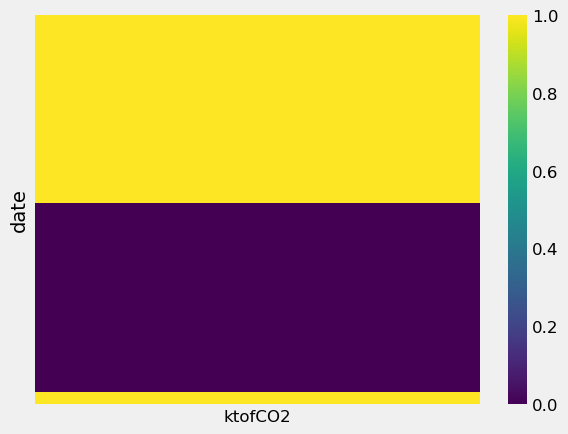

In [142]:
DMCP = DataMethCountryPreprocessing(France, df_France)
DMCP.CleaningAndRename()
DMCP.MissingValue()
DMCP.HandlingFormatDateIndex()

In [143]:
df = DMCP.df
df.replace(0.0, pd.np.nan, inplace=True)
df.head()

,ktofCO2
1960-12-31,NaN
1961-12-31,NaN
1962-12-31,NaN
1963-12-31,NaN
1964-12-31,NaN


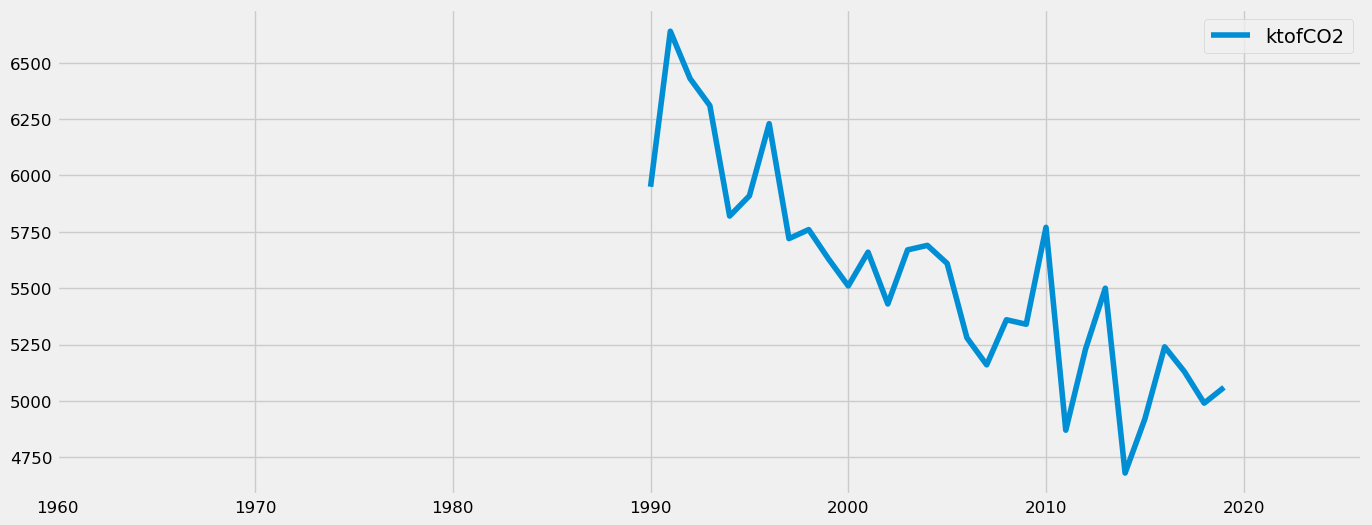

In [144]:
df.plot(figsize=(15, 6))
plt.show()

### Handling Missing data

<AxesSubplot: >

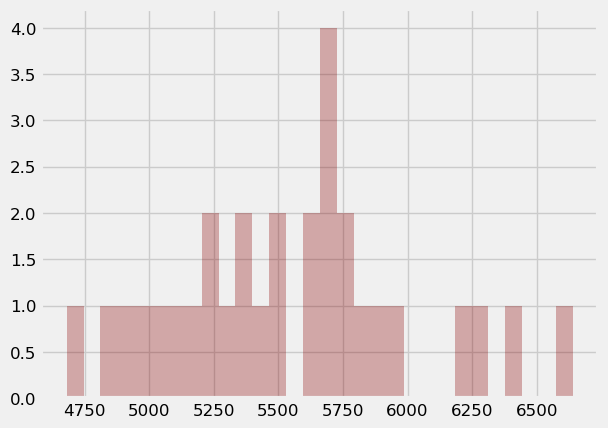

In [145]:
df['ktofCO2'].hist(bins=30,color='darkred',alpha=0.3)

<AxesSubplot: xlabel='ktofCO2'>

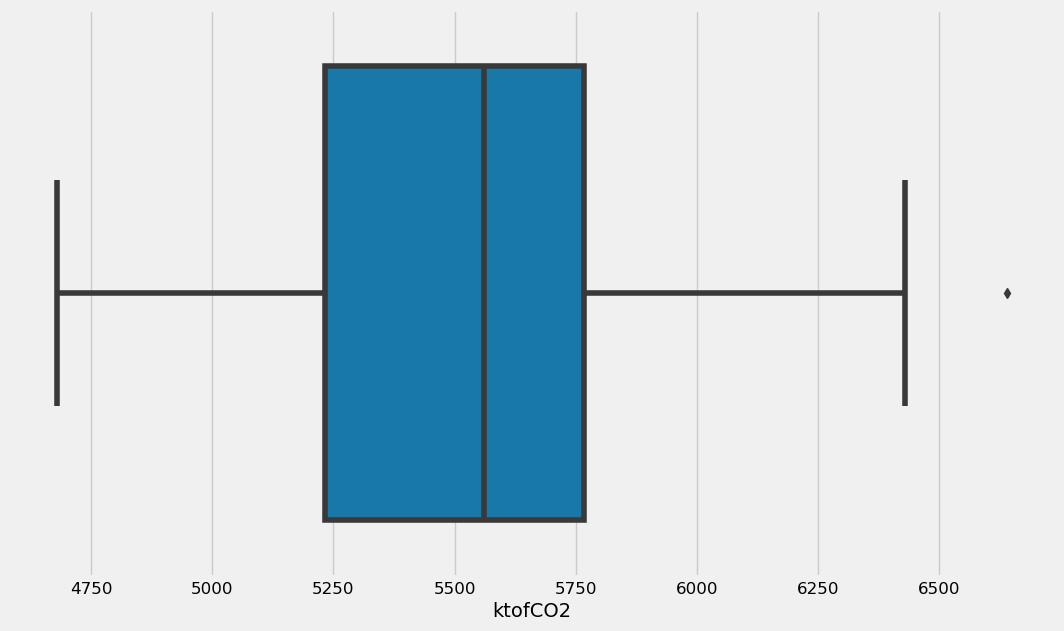

In [146]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='ktofCO2',data=df,palette='winter')

#### 1ere METHOD USING SIMPLE STATISTICAL METHOD such as mean, nedian, mode

In [ ]:
def imput_simple_mean(value_cols, kind= 'mean'):
    
    if pd.isnull(value_cols):
        if kind == 'mean' :
            return df['ktofCO2'].mean()
        elif kind == 'median' :
            return df['ktofCO2'].median()
        elif kind == 'mode' :
            return df['ktofCO2'].mode()[0]
            
    else:
        return value_cols

In [ ]:
df['ktofCO2'] = df['ktofCO2'].apply(lambda x: imput_simple_mean(x, 'mode'))

In [149]:
df['ktofCO2']

1960-12-31    4680.0
1961-12-31    4680.0
1962-12-31    4680.0
1963-12-31    4680.0
1964-12-31    4680.0
               ...  
2022-12-31    4680.0
2023-12-31    4680.0
2024-12-31    4680.0
2025-12-31    4680.0
2026-12-31    4680.0
Freq: A-DEC, Name: ktofCO2, Length: 67, dtype: float64

In [137]:
df['ktofCO2'].mode()[0]

4680.0

In [ ]:
#### 2eme METHOD : ML

In [210]:
#### 2eme METHOD : Custom imputation: KMEANS + STATISTICAL METHOD
predictors = predictors_id + QUERY_ID

In [262]:
world_methane_emission = wb.data.DataFrame(predictors, columns = 'series').reset_index()

In [267]:
world_methane_emission.to_csv('\world_methane_emission.csv')

In [269]:
world_methane_emission.head()

,economy,time,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.ZG
0,ABW,YR1960,NaN,NaN,NaN,NaN,NaN
1,ABW,YR1961,NaN,NaN,NaN,NaN,NaN
2,ABW,YR1962,NaN,NaN,NaN,NaN,NaN
3,ABW,YR1963,NaN,NaN,NaN,NaN,NaN
4,ABW,YR1964,NaN,NaN,NaN,NaN,NaN


In [273]:
world_methane_emission_df = world_methane_emission.copy()

#### Data cleaning

In [276]:
features = list(world_methane_emission_df.columns)[2:]
features

['EN.ATM.METH.AG.KT.CE',
 'EN.ATM.METH.AG.ZS',
 'EN.ATM.METH.EG.KT.CE',
 'EN.ATM.METH.EG.ZS',
 'EN.ATM.METH.ZG']

In [275]:
len(world_methane_emission_df)

16492

In [277]:
world_methane_emission_df = world_methane_emission_df.dropna(subset=features)
len(world_methane_emission_df)

3571

In [278]:
data = world_methane_emission_df[features].copy()
data

,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.ZG
155,5610.0,61.852260,240.0,25.248071,0.976719
156,5670.0,63.070078,200.0,22.914349,-3.173352
157,5720.0,64.341957,160.0,20.697413,-2.001814
158,5930.0,66.183036,120.0,18.080357,0.515891
159,6250.0,68.380744,80.0,15.317287,3.385871
...,...,...,...,...,...
16474,6410.0,60.989534,2450.0,16.841104,-7.153596
16475,6370.0,61.368015,2460.0,15.895954,-5.832041
16476,6050.0,60.139165,2510.0,16.103380,-17.467263
16477,6280.0,60.970874,2520.0,15.436893,-17.434600


#### Normalisation de la data

In [280]:
data = ((data - data.min()) / (data.max() - data.min())) * 10 + 1

In [281]:
data

,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.ZG
155,1.016750,7.425429,1.000850,3.541671,1.431682
156,1.016929,7.551940,1.000709,3.306740,1.413940
157,1.017079,7.684067,1.000567,3.083566,1.418949
158,1.017706,7.875325,1.000425,2.820112,1.429712
159,1.018661,8.103631,1.000283,2.541960,1.441981
...,...,...,...,...,...
16474,1.019139,7.335806,1.008680,2.695359,1.396924
16475,1.019019,7.375124,1.008716,2.600213,1.402574
16476,1.018064,7.247467,1.008893,2.621094,1.352833
16477,1.018751,7.333867,1.008928,2.554000,1.352972


In [310]:
from sklearn.cluster import KMeans
kmeans = KMeans(5)
kmeans.fit(data)

KMeans(n_clusters=5)

In [311]:
pd.DataFrame(kmeans.cluster_centers_, columns=features).T

,0,1,2,3,4
EN.ATM.METH.AG.KT.CE,1.154935,1.466130,7.194190,1.021558,1.251164
EN.ATM.METH.AG.ZS,2.851864,5.970096,5.880477,2.551361,8.753440
EN.ATM.METH.EG.KT.CE,1.454123,1.323399,6.474636,1.033187,1.055376
EN.ATM.METH.EG.ZS,7.546569,3.519282,4.473714,2.243221,2.087578
EN.ATM.METH.ZG,1.638061,1.432398,1.466159,1.554298,1.455969


In [312]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [313]:
centroids

array([[1.15493503, 2.85186364, 1.45412292, 7.54656859, 1.63806134],
       [1.46612991, 5.970096  , 1.32339937, 3.51928188, 1.43239783],
       [7.1941901 , 5.88047671, 6.47463636, 4.47371427, 1.46615933],
       [1.02155849, 2.55136109, 1.03318713, 2.24322076, 1.55429779],
       [1.25116351, 8.7534404 , 1.0553765 , 2.08757845, 1.45596852]])

In [314]:
world_methane_emission_df[kmeans.labels_ == 1][["economy"] + features]

,economy,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.AG.ZS,EN.ATM.METH.EG.KT.CE,EN.ATM.METH.EG.ZS,EN.ATM.METH.ZG
155,AFG,5610.0,61.852260,240.0,25.248071,0.976719
156,AFG,5670.0,63.070078,200.0,22.914349,-3.173352
170,AFG,8650.0,58.092680,280.0,26.863667,42.507847
171,AFG,8800.0,48.618785,500.0,38.674033,44.865082
172,AFG,9800.0,44.203879,730.0,45.060893,47.155454
...,...,...,...,...,...,...
16465,ZWE,5500.0,59.912854,2080.0,26.034858,-19.854916
16467,ZWE,6560.0,62.239089,2250.0,22.201139,-14.038182
16470,ZWE,6930.0,60.949868,2540.0,19.876869,-5.698852
16472,ZWE,6370.0,59.868421,2480.0,18.984962,-6.358752


In [315]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_clusters(data, labels, centroids):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

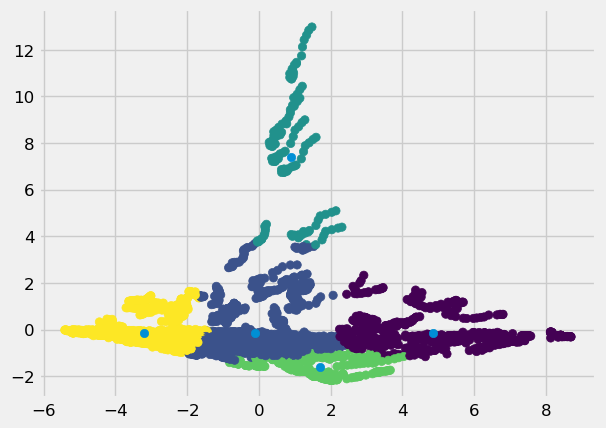

In [316]:
plot_clusters(data, labels, centroids.T)

In [268]:
len(world_methane_emission['economy'].unique())

266

In [264]:
world_methane_emission_afr = wb.data.DataFrame(predictors, wb.region.members('AFR'), columns = 'series').reset_index()